# Dependencies

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras.utils import to_categorical

import chess.svg
import chess

C:\Users\KIIT\.conda\envs\dl\Lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.12.2 when it was built against 1.12.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


# Preparing DataFrame

In [14]:
def create_image_dataframe(folder):
    data = []
    for filename in os.listdir(folder):
        data.append(filename)
    df = pd.DataFrame(data, columns = ["filename"])
    return df

In [15]:
train_df = create_image_dataframe("C:\\Users\\KIIT\\Summer Training\\ChessPositionScanner\\archive\\train")

In [16]:
train_df.head()

,filename
0,1b1B1b2-2pK2q1-4p1rB-7k-8-8-3B4-3rb3.jpeg
1,1b1b1b2-3r4-1rK4b-R7-R2R1k2-2Bp4-2P5-2r5.jpeg
2,1B1B1K2-3p1N2-6k1-R7-5P2-4q3-7R-1B6.jpeg
3,1b1B1K2-R2B4-7P-3b4-3R2B1-8-3R4-4Qk2.jpeg
4,1b1b1n2-1K1RN1b1-3pbN2-8-4q1k1-4P3-8-2n3N1.jpeg


In [17]:
test_df = create_image_dataframe("C:\\Users\\KIIT\\Summer Training\\ChessPositionScanner\\archive\\test")

In [18]:
test_df.head()

,filename
0,1b1B1Qr1-7p-6r1-2P5-4Rk2-1K6-4B3-8.jpeg
1,1B1B2K1-1B6-5N2-6k1-8-8-8-4nq2.jpeg
2,1b1b2K1-1r6-2P4p-1b1p4-4N1k1-3B2Q1-2q5-2N2q2.jpeg
3,1b1b2k1-K2B1q2-R3B2p-3b1NR1-5p2-3N4-8-5N2.jpeg
4,1B1B3R-8-1b2k3-8-2n5-1rK5-b7-8.jpeg


In [45]:
def extract_FENs(df):
    data = df["filename"]
    fens = []
    for s in data:
        fens.append(s[:-5])
    df.insert(1, "FEN", fens)
    return df

In [46]:
train_df = extract_FENs(train_df)

In [47]:
train_df.head()

,filename,FEN
0,1b1B1b2-2pK2q1-4p1rB-7k-8-8-3B4-3rb3.jpeg,1b1B1b2-2pK2q1-4p1rB-7k-8-8-3B4-3rb3
1,1b1b1b2-3r4-1rK4b-R7-R2R1k2-2Bp4-2P5-2r5.jpeg,1b1b1b2-3r4-1rK4b-R7-R2R1k2-2Bp4-2P5-2r5
2,1B1B1K2-3p1N2-6k1-R7-5P2-4q3-7R-1B6.jpeg,1B1B1K2-3p1N2-6k1-R7-5P2-4q3-7R-1B6
3,1b1B1K2-R2B4-7P-3b4-3R2B1-8-3R4-4Qk2.jpeg,1b1B1K2-R2B4-7P-3b4-3R2B1-8-3R4-4Qk2
4,1b1b1n2-1K1RN1b1-3pbN2-8-4q1k1-4P3-8-2n3N1.jpeg,1b1b1n2-1K1RN1b1-3pbN2-8-4q1k1-4P3-8-2n3N1


In [48]:
test_df = extract_FENs(test_df)

In [49]:
test_df.head()

,filename,FEN
0,1b1B1Qr1-7p-6r1-2P5-4Rk2-1K6-4B3-8.jpeg,1b1B1Qr1-7p-6r1-2P5-4Rk2-1K6-4B3-8
1,1B1B2K1-1B6-5N2-6k1-8-8-8-4nq2.jpeg,1B1B2K1-1B6-5N2-6k1-8-8-8-4nq2
2,1b1b2K1-1r6-2P4p-1b1p4-4N1k1-3B2Q1-2q5-2N2q2.jpeg,1b1b2K1-1r6-2P4p-1b1p4-4N1k1-3B2Q1-2q5-2N2q2
3,1b1b2k1-K2B1q2-R3B2p-3b1NR1-5p2-3N4-8-5N2.jpeg,1b1b2k1-K2B1q2-R3B2p-3b1NR1-5p2-3N4-8-5N2
4,1B1B3R-8-1b2k3-8-2n5-1rK5-b7-8.jpeg,1B1B3R-8-1b2k3-8-2n5-1rK5-b7-8


In [62]:
train_df.to_csv("train.csv", index = False)
test_df.to_csv("test.csv", index = False)

In [61]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# Helper Functions

In [2]:
def process_image(df):
    data = []
    for file in df["filename"]:
        im = Image.open(file)
        im = im.resize((200, 200))
        im = im.convert('L')
        ar = np.array(im)
        square = []
        for i in range(0, 200, 25):
            for j in range(0, 200, 25):
                square.append(ar[i:i+25, j:j+25])
        data.append(square)
    data = np.array(data)
    return data

In [3]:
def fentoOHE(df):
    data = []
    for fen in df["FEN"]:
        board = np.zeros((64, 13))
        i = 0
        for x in fen:
            if x == '-':
                continue
            if x not in fenchars:
                skip = int(x)
                while skip != 0:
                    board[i][12] = 1
                    i += 1
                    skip -= 1
            else:
                board[i][fenchars[x]] = 1
                i += 1
        data.append(board)
    data = np.array(data)
    return data

In [4]:
def OHEtofen(arr):
    data = []
    for board in arr:
        tempfen = ""
        for square in board:
            for i in range(0, 13):
                if square[i] == 1:
                    tempfen += fenchars_list[i]
        offset = 0
        empty = 0
        fen = ""
        for x in tempfen:
            if x == 'x':
                empty += 1
                offset += 1
            else:
                if empty != 0:
                    fen += str(empty)
                    empty = 0
                fen += x
                offset += 1
            if offset == 8:
                if empty != 0:
                    fen += str(empty)
                    empty = 0
                fen += '-'
                offset = 0
        fen = fen[:-1]
        data.append(fen)
    data = pd.DataFrame(data)
    return data

In [5]:
def test_image(im):
    im = im.resize((200, 200))
    im = im.convert('L')
    arr = np.array(im)
    data = []
    for i in range(0, 200, 25):
        for j in range(0, 200, 25):
            data.append(arr[i: i+25, j:j+25])
    data = np.array(data)
    data = data.reshape((64, 25, 25, 1))
    pred = model.predict(data)
    pred = pred.argmax(axis = 1)
    pred = to_categorical(pred)
    pred = pred.reshape((1, 64, 13))
    fen = OHEtofen(pred)[0][0].replace('-', '/')
    return fen

# Data Preprocessing

In [9]:
fenchars_list = ['r', 'n', 'b', 'q', 'k', 'p', 'R', 'N', 'B', 'Q', 'K', 'P', 'x']

fenchars = {
    'r': 0,
    'n': 1,
    'b': 2,
    'q': 3,
    'k': 4,
    'p': 5,
    'R': 6,
    'N': 7,
    'B': 8,
    'Q': 9,
    'K': 10,
    'P': 11,
    'x': 12
}

In [58]:
train_df["filename"] = "archive\\train\\" + train_df["filename"].astype(str)
test_df["filename"] = "archive\\test\\" + test_df["filename"].astype(str)

In [219]:
X_train = process_image(train_df)
X_test = process_image(test_df)

np.save("X_train.npy", X_train)
np.save("X_test.npy", X_test)

X_train = np.load("X_train.npy")
X_test = np.load("X_test.npy")

In [220]:
X_train.shape

(80000, 64, 25, 25)

In [212]:
X_test.shape

(20000, 64, 25, 25)

In [103]:
y_train = fentoOHE(train_df)
y_test = fentoOHE(test_df)

np.save("y_train.npy", y_train)
np.save("y_test.npy", y_test)

y_train = np.load("y_train.npy")
y_test = np.load("y_test.npy")

In [106]:
y_train.shape

(80000, 64, 13)

In [104]:
y_test.shape

(20000, 64, 13)

In [23]:
n = 2000
index = np.random.choice(X_train.shape[0], n, replace=False)  

In [24]:
X_train = X_train[index]
y_train = y_train[index]
X_test = X_test[:200]
y_test = y_test[:200]

X_train = X_train.reshape((-1, 25, 25))
y_train = y_train.reshape((-1, 13))
X_test = X_test.reshape((-1, 25, 25))
y_test = y_test.reshape((-1, 13))

In [40]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((128000, 25, 25, 1), (12800, 25, 25, 1), (128000, 13), (12800, 13))

# Model

In [41]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (3,3), activation = "relu", input_shape = X_train.shape[1:]))
model.add(MaxPool2D(pool_size=(2, 2), strides = 2))
model.add(Dropout(0.2))
model.add(Conv2D(filters = 32, kernel_size = (5,5), activation = "relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides = 2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(13, activation = 'softmax'))

In [42]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 23, 23, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 11, 11, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 11, 11, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 32)          25632     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 3, 3, 32)          0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 3, 3, 32)         

In [43]:
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])

# Training

In [46]:
epochs = 100
history = model.fit(X_train, y_train, batch_size = 64, epochs = epochs, validation_data = (X_val, y_val))

Epoch 1/100
2000/2000 [==============================] - 81s 37ms/step - loss: 0.3812 - accuracy: 0.9293 - val_loss: 0.0509 - val_accuracy: 0.9890
Epoch 2/100
2000/2000 [==============================] - 81s 41ms/step - loss: 0.0391 - accuracy: 0.9878 - val_loss: 0.0370 - val_accuracy: 0.9946
Epoch 3/100
2000/2000 [==============================] - 78s 39ms/step - loss: 0.0264 - accuracy: 0.9916 - val_loss: 0.0156 - val_accuracy: 0.9937
Epoch 4/100
2000/2000 [==============================] - 80s 40ms/step - loss: 0.0234 - accuracy: 0.9925 - val_loss: 0.0121 - val_accuracy: 0.9954
Epoch 5/100
2000/2000 [==============================] - 79s 39ms/step - loss: 0.0186 - accuracy: 0.9943 - val_loss: 0.0094 - val_accuracy: 0.9960
Epoch 6/100
2000/2000 [==============================] - 79s 39ms/step - loss: 0.0177 - accuracy: 0.9946 - val_loss: 0.0067 - val_accuracy: 0.9973
Epoch 7/100
2000/2000 [==============================] - 82s 41ms/step - loss: 0.0179 - accuracy: 0.9950 - val_loss: 0

2000/2000 [==============================] - 78s 39ms/step - loss: 0.0182 - accuracy: 0.9982 - val_loss: 4.3831e-04 - val_accuracy: 0.9999
Epoch 57/100
2000/2000 [==============================] - 79s 39ms/step - loss: 0.0185 - accuracy: 0.9983 - val_loss: 7.5069e-05 - val_accuracy: 1.0000
Epoch 58/100
2000/2000 [==============================] - 78s 39ms/step - loss: 0.0209 - accuracy: 0.9980 - val_loss: 0.0016 - val_accuracy: 0.9995
Epoch 59/100
2000/2000 [==============================] - 80s 40ms/step - loss: 0.0200 - accuracy: 0.9980 - val_loss: 0.0012 - val_accuracy: 0.9996
Epoch 60/100
2000/2000 [==============================] - 79s 39ms/step - loss: 0.0172 - accuracy: 0.9986 - val_loss: 5.1805e-06 - val_accuracy: 1.0000
Epoch 61/100
2000/2000 [==============================] - 78s 39ms/step - loss: 0.0198 - accuracy: 0.9981 - val_loss: 3.5637e-04 - val_accuracy: 0.9999
Epoch 62/100
2000/2000 [==============================] - 78s 39ms/step - loss: 0.0150 - accuracy: 0.9985 - v

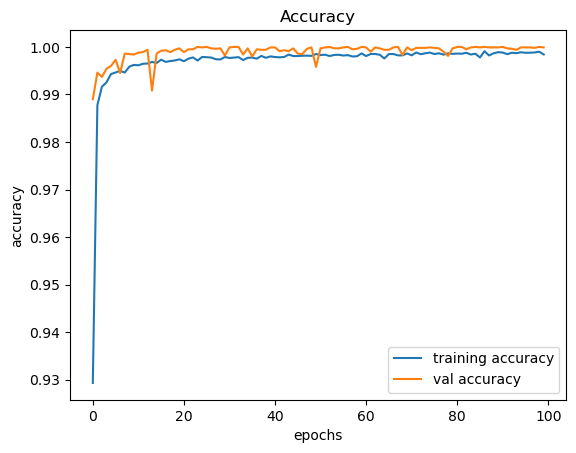

In [47]:
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

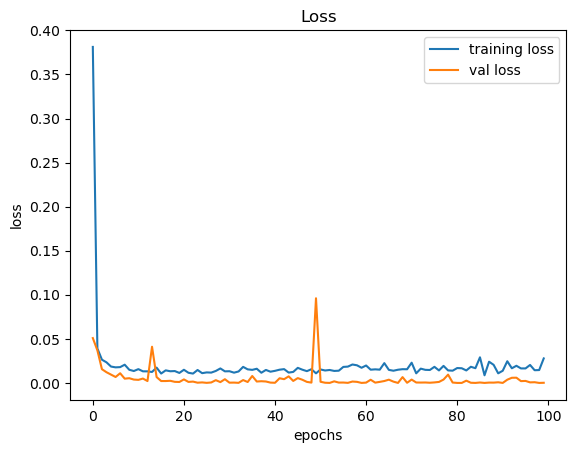

In [48]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [49]:
model.save("model1.h5")

C:\Users\KIIT\.conda\envs\dl\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [6]:
model = load_model("model1.h5")

# Evaluation

In [51]:
y_pred = model.predict(X_test)

400/400 [==============================] - 8s 8ms/step


In [53]:
y_pred = y_pred.argmax(axis = 1)
y_test = y_test.argmax(axis = 1)

In [78]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)*100

99.984375

In [55]:
prediction = to_categorical(y_pred)

In [56]:
prediction

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [57]:
prediction = prediction.reshape((-1, 64, 13))

In [58]:
prediction.shape

(200, 64, 13)

In [59]:
predicted_fens = OHEtofen(prediction)

In [62]:
pred_fen = np.array(predicted_fens[0])
test_fen = np.array(test_df[:200]["FEN"])

In [63]:
final_accuracy = (pred_fen == test_fen).astype(float).mean()

print("Final Accuracy: {:1.5f}%".format(final_accuracy*100))

Final Accuracy: 99.00000%


In [7]:
im = Image.open("test2.png")

In [10]:
fen = test_image(im)

2/2 [==============================] - 0s 10ms/step


Input image : 


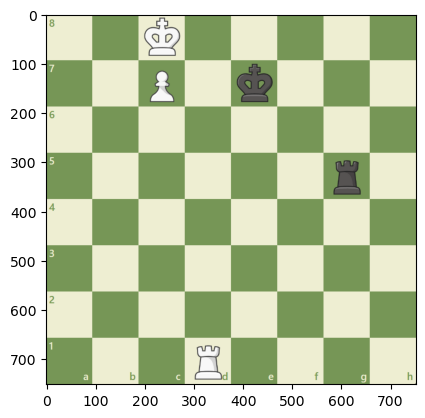

predicted fen : 2K5/2P1k3/8/6r1/8/8/8/3R4


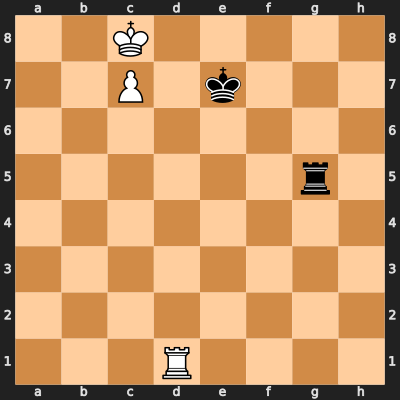

In [11]:
print(f"Input image : ")
plt.imshow(im)
plt.show()
print(f"predicted fen : {fen}")
board = chess.Board(fen)
chess.svg.board(board, size = 400)

In [12]:
im = Image.open("test3.png")

In [13]:
fen = test_image(im)

2/2 [==============================] - 0s 9ms/step


Input image : 


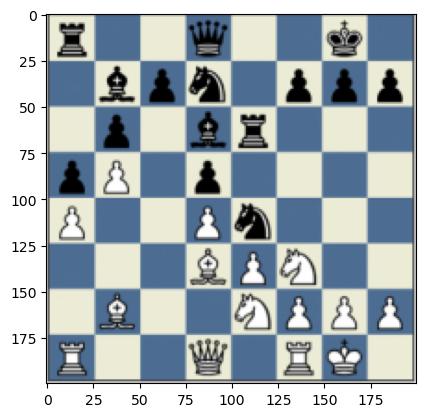

predicted fen : r2q2P1/1bpn1ppp/1p1br3/pP1p4/P2Pn3/3BPN2/1B2NPPP/R2Q1Rk1


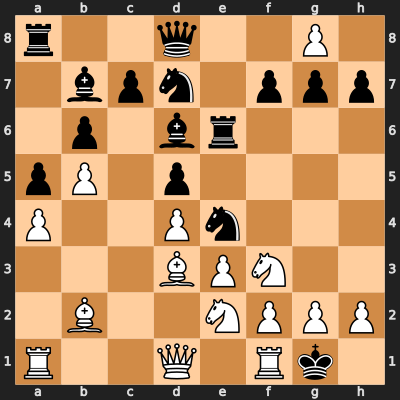

In [14]:
print(f"Input image : ")
plt.imshow(im)
plt.show()
print(f"predicted fen : {fen}")
board = chess.Board(fen)
chess.svg.board(board, size = 400)

In [15]:
im = Image.open("test5.png")

In [16]:
fen = test_image(im)

2/2 [==============================] - 0s 7ms/step


Input image : 


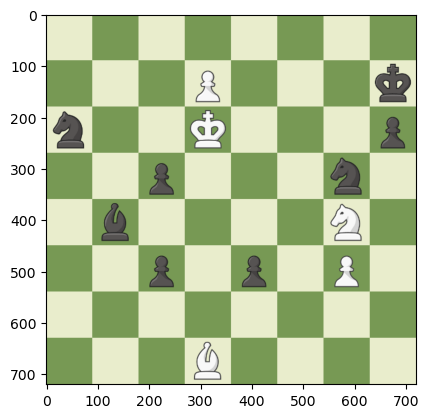

predicted fen : 8/3P3k/n2K3p/2p3n1/1b4N1/2p1p1P1/8/3B4


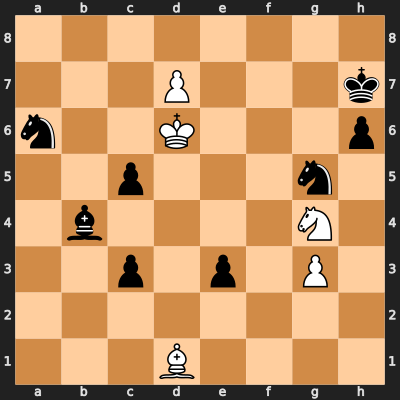

In [17]:
print(f"Input image : ")
plt.imshow(im)
plt.show()
print(f"predicted fen : {fen}")
board = chess.Board(fen)
chess.svg.board(board, size = 400)

In [ ]:
#R4Z0Rx